### Load Libraries

In [39]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from src.VAE_CelebA import FaceEncoderV, FaceDecoder
from src.utils.data_io import show_images, TensorDataset

### Conig parameter

In [40]:
# Configuration parameters
N = 256
MODEL_DIR_VAE = "./models/Celeb/VAE/"
MODEL_NAME = "VAE"


C = 3
H = 128
W = 128
CELEBA_ATTRIBUTES = [
'5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald',
'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry',
'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses',
'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face',
'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat',
'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
]


USE_BATCH_NORM = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = './data/CelebA/'

In [41]:
def load_models(n=N, use_batch_norm=USE_BATCH_NORM, device=DEVICE):
    """Load trained encoder and decoder models"""
    model_file_enc = MODEL_DIR_VAE + f"{n}_encoder.pth"
    model_file_dec = MODEL_DIR_VAE + f"{n}_decoder.pth"
    
    enc_model = FaceEncoderV(C=C, H=H, W=W, N=n, use_BatchNorm=use_batch_norm).to(device)
    enc_model.load_state_dict(torch.load(model_file_enc, weights_only=True))
    enc_model.eval()
    
    dec_model = FaceDecoder(C=C, H=H, W=W, N=n).to(device)
    dec_model.load_state_dict(torch.load(model_file_dec, weights_only=True))
    dec_model.eval()
    
    return enc_model, dec_model

enc_model, dec_model = load_models()

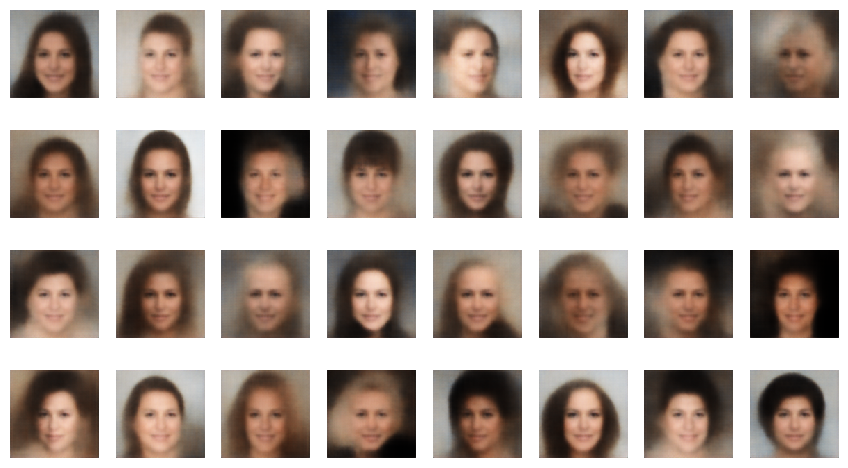

In [42]:
def generate_samples_from_normal_dist(decoder, n_samples=32, latent_dim=N, z_mu=0, z_sigma=1, device=DEVICE):
    """Generate images by sampling from latent space"""
    z = z_sigma * torch.randn((n_samples, latent_dim)).to(device) + z_mu
    
    with torch.inference_mode():
        generated_images = decoder(z)
        show_images(generated_images.to('cpu').detach(), num=n_samples, 
                   num_per_row=8, title=f'{N}_{MODEL_NAME}_generated_samples', save_fig=True, save_dir=f"./results/CelebA/{MODEL_NAME}/")
    
    return generated_images

gen_samples = generate_samples_from_normal_dist(dec_model, n_samples=32, latent_dim=N, z_mu=0, z_sigma=1)

In [43]:
def load_mnist_data(data_dir=DATA_DIR):
    """Load tinyCelebA dataset from files"""
    train_images = torch.load(os.path.join(data_dir, 'tinyCelebA_train_images.pt'))
    train_labels = torch.load(os.path.join(data_dir, 'tinyCelebA_train_labels.pt'))
    return train_images, train_labels

train_images, train_labels = load_mnist_data()
train_images.shape, train_labels.shape

(torch.Size([16000, 3, 128, 128]), torch.Size([16000, 40]))

Morphing visualization saved to ./results/CelebA/VAE/256_VAE_morphing_Smiling.png


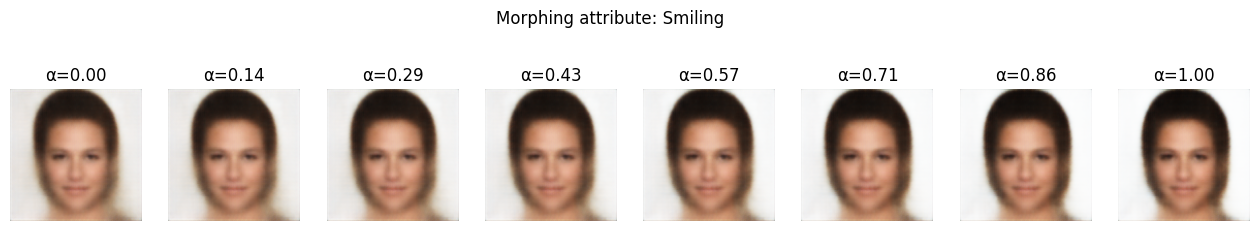

Morphing visualization saved to ./results/CelebA/VAE/256_VAE_morphing_Male.png


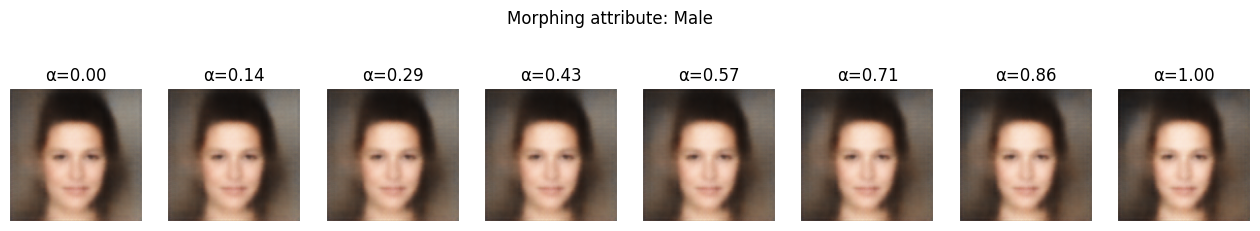

In [44]:
def morph_between_attributes(encoder, decoder, images, labels, 
                          target_attribute, samples_per_stage=8, num_steps=8,
                          attributes=CELEBA_ATTRIBUTES, device=DEVICE):
    """
    特定の属性を変化させるモーフィングを生成する関数
    
    Args:
        encoder: エンコーダーモデル
        decoder: デコーダーモデル
        images: 画像テンソル
        labels: 属性ラベルテンソル
        target_attribute: モーフィングしたい属性名（例：'Smiling', 'Male'）
        samples_per_stage: 各ステージ（属性あり/なし）で使用するサンプル数
        num_steps: モーフィングのステップ数
        attributes: 属性名のリスト
        device: 計算デバイス
    """
    # 属性インデックスを取得
    if target_attribute in attributes:
        attribute_idx = attributes.index(target_attribute)
    else:
        print(f"Error: Attribute '{target_attribute}' not found in the list.")
        return
    
    # 指定された属性に基づいてサンプルを選択
    pos_indices = torch.where(labels[:, attribute_idx] > 0)[0]
    neg_indices = torch.where(labels[:, attribute_idx] <= 0)[0]
    
    if len(pos_indices) < samples_per_stage or len(neg_indices) < samples_per_stage:
        print(f"Warning: Not enough samples with/without attribute '{target_attribute}'")
        samples_per_stage = min(len(pos_indices), len(neg_indices))
    
    # サンプルを選択
    pos_selected = pos_indices[:samples_per_stage]
    neg_selected = neg_indices[:samples_per_stage]
    
    # 潜在表現を取得
    with torch.inference_mode():
        # 属性ありの平均的な潜在表現
        z_pos_list = []
        for idx in pos_selected:
            img = images[idx:idx+1].to(device)
            z, _, _ = encoder(img)
            z_pos_list.append(z)
        
        # 属性なしの平均的な潜在表現
        z_neg_list = []
        for idx in neg_selected:
            img = images[idx:idx+1].to(device)
            z, _, _ = encoder(img)
            z_neg_list.append(z)
        
        # 平均を計算
        z_pos_mean = torch.mean(torch.cat(z_pos_list), dim=0, keepdim=True)
        z_neg_mean = torch.mean(torch.cat(z_neg_list), dim=0, keepdim=True)
        
        # 属性方向ベクトルを計算
        attribute_direction = z_pos_mean - z_neg_mean
        
        # モーフィング用に任意のサンプルを選択
        base_idx = neg_selected[0]  # 属性なしサンプルをベースに
        base_img = images[base_idx:base_idx+1].to(device)
        base_z, _, _ = encoder(base_img)
        
        # モーフィング結果の表示用に画像を生成
        fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 3))
        
        for i in range(num_steps):
            # 補間の割合
            alpha = i / (num_steps - 1) if num_steps > 1 else 0
            
            # ベースの潜在表現に属性方向を徐々に加える
            interp_z = base_z + alpha * attribute_direction
            
            # 画像にデコード
            morphed_img = decoder(interp_z)
            img_np = morphed_img.cpu().squeeze().permute(1, 2, 0).detach().numpy()
            
            # 値を0-1の範囲に正規化
            img_np = np.clip(img_np, 0, 1)
            
            # 画像の表示
            axes[i].imshow(img_np)
            axes[i].set_title(f"α={alpha:.2f}")
            axes[i].axis('off')
        
        plt.suptitle(f"Morphing attribute: {target_attribute}")
        
        # 結果を保存
        os.makedirs(f"./results/CelebA/{MODEL_NAME}", exist_ok=True)
        save_path = os.path.join(f"./results/CelebA/{MODEL_NAME}", 
                               f"{N}_{MODEL_NAME}_morphing_{target_attribute}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Morphing visualization saved to {save_path}")
        
        plt.show()

# 使用例:
# 「Smiling」属性のモーフィング
morph_between_attributes(enc_model, dec_model, train_images, train_labels, 
                        target_attribute='Smiling', samples_per_stage=10, num_steps=8)

# 「Male」属性のモーフィング
morph_between_attributes(enc_model, dec_model, train_images, train_labels, 
                        target_attribute='Male', samples_per_stage=10, num_steps=8)


Analyzing latent distribution using 500 samples
Latent distribution visualization saved to ./results/CelebA/VAE/256_VAE_latent_distribution.png


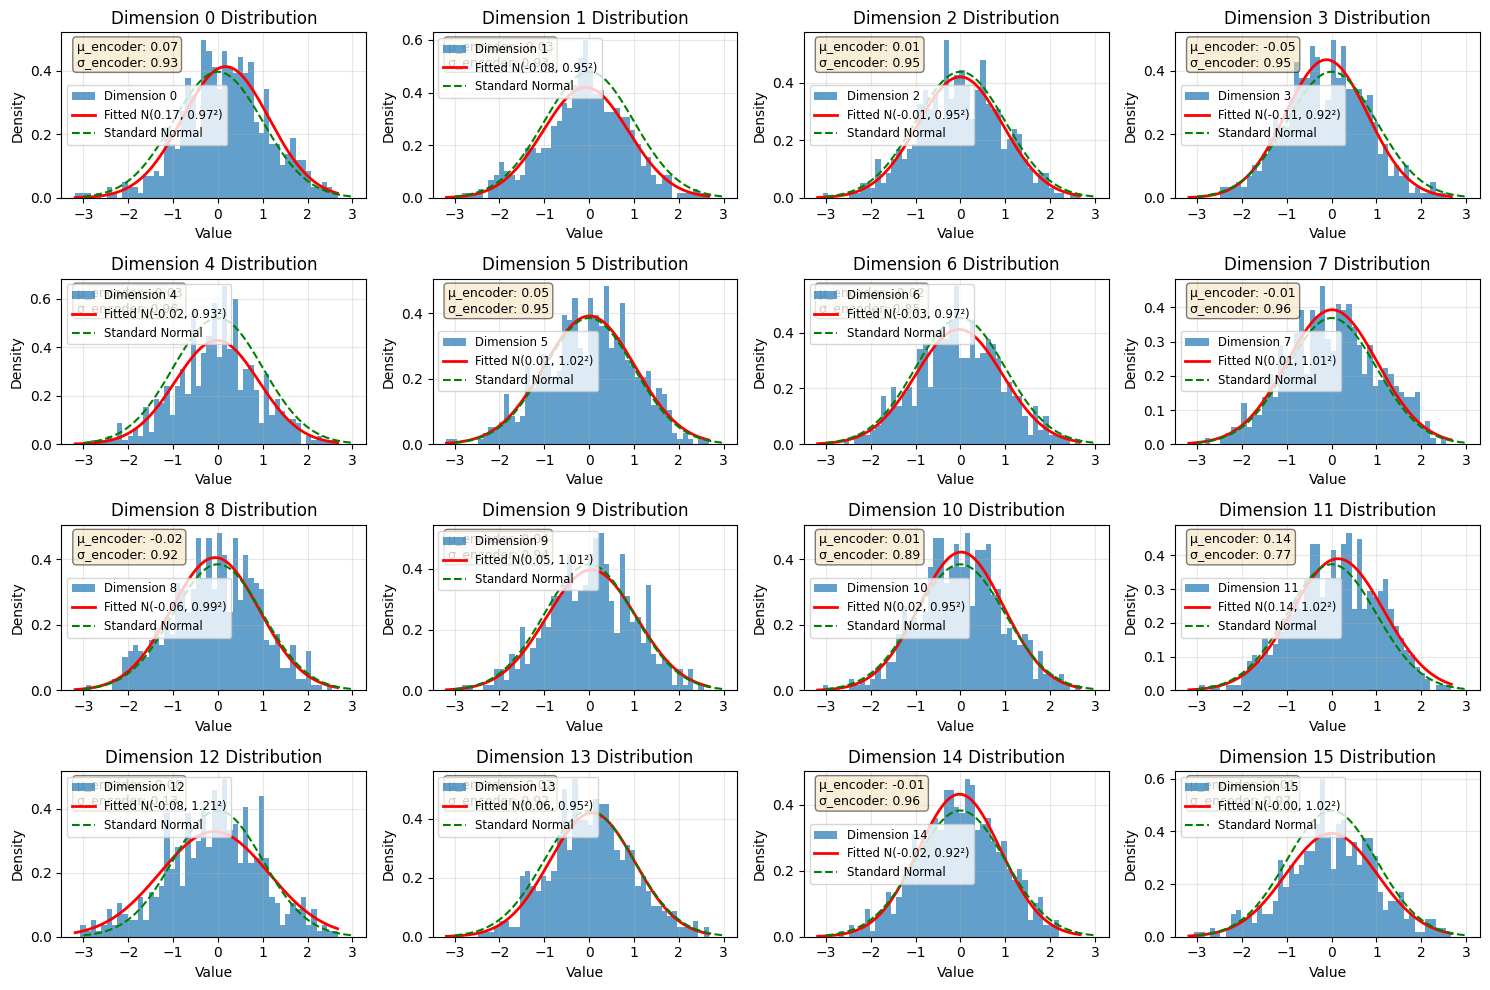

Latent statistics visualization saved to ./results/CelebA/VAE/256_VAE_latent_stats.png


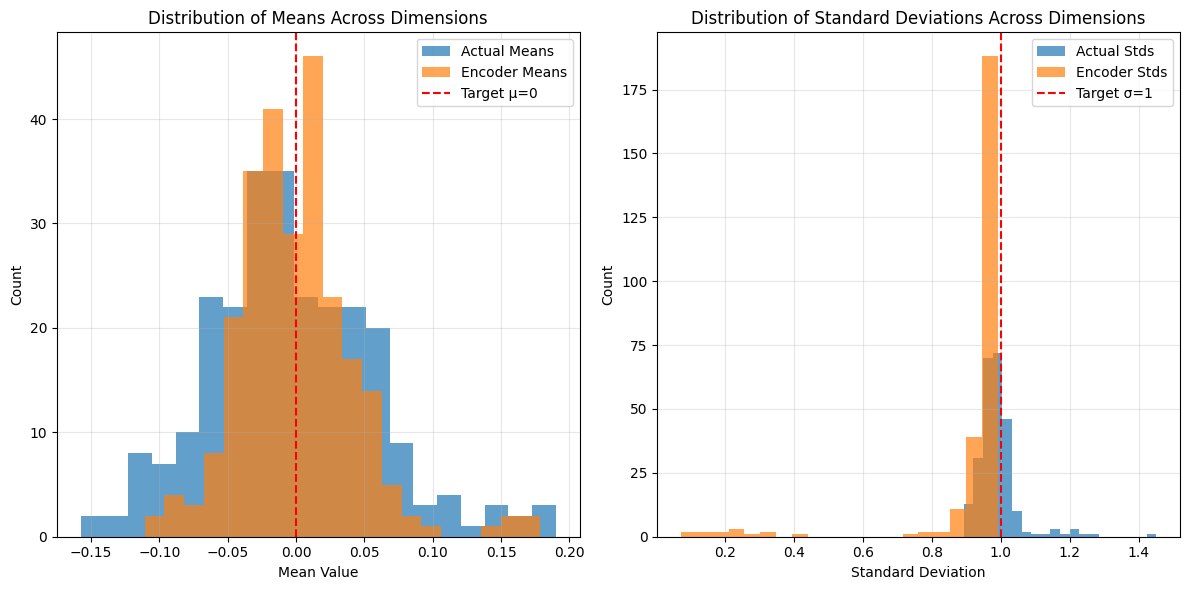

正規性検定結果 (Shapiro-Wilk Test):
次元	p値		正規性
----------------------------------------
0	0.071346	正規分布に従う
1	0.066487	正規分布に従う
2	0.997696	正規分布に従う
3	0.969920	正規分布に従う
4	0.325284	正規分布に従う
5	0.493413	正規分布に従う
6	0.528158	正規分布に従う
7	0.034087	正規分布に従わない
8	0.385129	正規分布に従う
9	0.160574	正規分布に従う
10	0.781628	正規分布に従う
11	0.214068	正規分布に従う
12	0.000387	正規分布に従わない
13	0.064219	正規分布に従う
14	0.256450	正規分布に従う
15	0.607585	正規分布に従う
16	0.801197	正規分布に従う
17	0.012114	正規分布に従わない
18	0.020994	正規分布に従わない
19	0.910560	正規分布に従う


In [45]:
def visualize_latent_distribution(encoder, images, n_dims=8, bins=50, figsize=(15, 10), device=DEVICE):
    """
    VAEの潜在空間の分布を確認するためのヒストグラム可視化
    
    Args:
        encoder: エンコーダーモデル
        images: 可視化に使用する画像データ
        n_dims: 可視化する次元数（最初のn_dims次元を表示）
        bins: ヒストグラムのビン数
        figsize: 図のサイズ
        device: 計算デバイス
    """
    # サンプル数を確認
    print(f"Analyzing latent distribution using {len(images)} samples")
    
    # 埋め込みを生成
    with torch.inference_mode():
        embeddings, mu, lnvar = encoder(images.to(device))
    
    # CPUに移動してNumPy配列に変換
    embeddings_np = embeddings.cpu().numpy()
    mu_np = mu.cpu().numpy()
    std_np = np.exp(0.5 * lnvar.cpu().numpy())  # lnvarから標準偏差を計算
    
    # 全次元数を取得
    total_dims = embeddings_np.shape[1]
    n_dims = min(n_dims, total_dims)  # 表示する次元数を調整
    
    # 標準正規分布のx軸の範囲を計算（比較用）
    x_range = np.linspace(-3, 3, 1000)  # -3σから+3σまで
    normal_pdf = np.exp(-0.5 * x_range**2) / np.sqrt(2 * np.pi)  # 標準正規分布のPDF
    
    # サブプロットの行数と列数を計算
    n_rows = (n_dims + 3) // 4  # 4列で表示
    n_cols = min(4, n_dims)
    
    # プロット
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_dims > 1 else [axes]
    
    for i in range(n_dims):
        ax = axes[i]
        
        # i番目の次元のデータ
        dim_data = embeddings_np[:, i]
        
        # ヒストグラムを描画
        counts, bins, patches = ax.hist(dim_data, bins=bins, density=True, alpha=0.7, 
                                       label=f'Dimension {i}')
        
        # 平均と標準偏差を計算
        mean = np.mean(dim_data)
        std = np.std(dim_data)
        
        # VAEのmu, stdの平均値
        encoder_mean = np.mean(mu_np[:, i])
        encoder_std = np.mean(std_np[:, i])
        
        # 対応する正規分布を計算して重ねる
        x = np.linspace(min(bins), max(bins), 1000)
        pdf = np.exp(-0.5 * ((x - mean) / std)**2) / (std * np.sqrt(2 * np.pi))
        ax.plot(x, pdf, 'r-', linewidth=2, label=f'Fitted N({mean:.2f}, {std:.2f}²)')
        
        # 標準正規分布も比較用に表示
        scaled_normal = normal_pdf * (max(counts) / max(normal_pdf)) * 0.8
        ax.plot(x_range, scaled_normal, 'g--', linewidth=1.5, label='Standard Normal')
        
        # テキスト情報を追加
        ax.text(0.05, 0.95, f'μ_encoder: {encoder_mean:.2f}\nσ_encoder: {encoder_std:.2f}', 
               transform=ax.transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        ax.set_title(f'Dimension {i} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend(fontsize='small')
        ax.grid(True, alpha=0.3)
    
    # 使用していないサブプロットを非表示にする
    for i in range(n_dims, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    
    # 結果を保存
    save_dir = f"./results/CelebA/{MODEL_NAME}"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{total_dims}_{MODEL_NAME}_latent_distribution.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Latent distribution visualization saved to {save_path}")
    
    plt.show()

    # 分布の統計情報をまとめる
    plt.figure(figsize=(12, 6))
    
    # 全次元の平均と標準偏差
    all_means = np.mean(embeddings_np, axis=0)
    all_stds = np.std(embeddings_np, axis=0)
    all_encoder_means = np.mean(mu_np, axis=0)
    all_encoder_stds = np.mean(std_np, axis=0)
    
    # 平均のヒストグラム
    plt.subplot(1, 2, 1)
    plt.hist(all_means, bins=20, alpha=0.7, label='Actual Means')
    plt.hist(all_encoder_means, bins=20, alpha=0.7, label='Encoder Means')
    plt.axvline(x=0, color='r', linestyle='--', label='Target μ=0')
    plt.title('Distribution of Means Across Dimensions')
    plt.xlabel('Mean Value')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 標準偏差のヒストグラム
    plt.subplot(1, 2, 2)
    plt.hist(all_stds, bins=20, alpha=0.7, label='Actual Stds')
    plt.hist(all_encoder_stds, bins=20, alpha=0.7, label='Encoder Stds')
    plt.axvline(x=1, color='r', linestyle='--', label='Target σ=1')
    plt.title('Distribution of Standard Deviations Across Dimensions')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 統計情報の保存
    stats_path = os.path.join(save_dir, f"{total_dims}_{MODEL_NAME}_latent_stats.png")
    plt.savefig(stats_path, dpi=300, bbox_inches='tight')
    print(f"Latent statistics visualization saved to {stats_path}")
    
    plt.show()

    return embeddings_np, mu_np, std_np

# 使用例
# 一部のサンプルデータを使用（速度向上のため）
sample_idx = torch.randperm(len(train_images))[:500]
sample_images = train_images[sample_idx]

# 埋め込み分布の可視化
embeddings, mu, std = visualize_latent_distribution(enc_model, sample_images, n_dims=16, bins=50)

# 全次元の正規性を評価
from scipy import stats

# 各次元についてシャピロ-ウィルク検定を実行
print("正規性検定結果 (Shapiro-Wilk Test):")
print("次元\tp値\t\t正規性")
print("-" * 40)

# 最初の20次元だけテスト
for i in range(min(20, embeddings.shape[1])):
    stat, p = stats.shapiro(embeddings[:, i])
    normal = "正規分布に従う" if p > 0.05 else "正規分布に従わない"
    print(f"{i}\t{p:.6f}\t{normal}")